# Global search using Lookup Table
## Synthetic model with 2 layers

In [1]:
%matplotlib widget

In [2]:
# Import libraries
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from mpl_toolkits import mplot3d
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from keras.optimizers import SGD
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots

import sys
sys.path.insert(1, '../src')

from PlotModel import PlotModelCond_2lay, Plot3Models_2lay, PlotErrorSpace, PlotData
from EM1D import EMforward2lay, GlobalSearch, ErrorSpace

2023-07-07 14:50:07.090689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 14:50:07.190410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 14:50:07.191632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 14:50:09.116223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1. Define the synthetic model

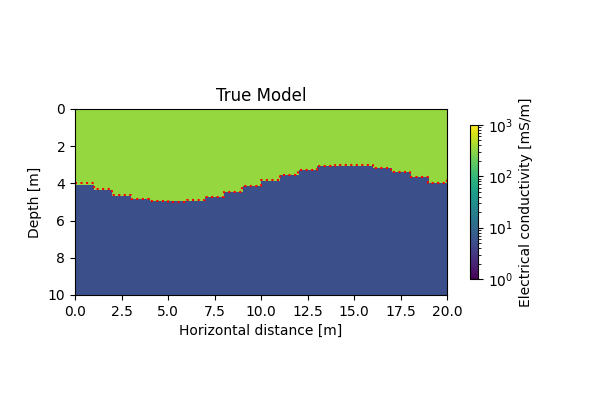

In [3]:
# Import the conductivities and thicknesses used to create the LU table

conds = np.load('../data/conds_samples.npy')
thick = np.load('../data/thick_samples.npy')

# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[42]+conds[3], conds[14]-conds[3]] # conductivities of the layers
sigmas = np.ones((npos, nlayer))*sig_ini # conductivity array

x = np.linspace(0, 20, npos) # Horizontal positions array
thk1 = np.ones_like(x)*4 + np.sin(2*np.pi*x)   # wave boundary for the layers

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1 

PlotModelCond_2lay(sigmas, depths)
plt.title('True Model')
plt.show()

### 2. Create synthetic data to test the global search

In [4]:
# Create empty array for true model in each position
model = np.stack((sigmas[:,0], sigmas[:,1], depths[:,1]), axis=1)

# Create empty array for true data in each position
data_true=[]

# Simulate data in each position
for i in range(npos):
    data_true.append(EMforward2lay(sigmas[i][0], sigmas[i][1], depths[i][1], height = 0.10)) 
    
data_true = np.array(data_true)

### 3. Normalize data sets due to offset

In [5]:
LUT = np.load('../data/LookupTable2Layers.npy')

norm = np.array([4, 2, 1])

LUT_norm = LUT[:] * np.hstack([norm, norm, norm, norm, norm, norm])
data_true_norm = data_true[:] * np.hstack([norm, norm, norm, norm, norm, norm])

### 3. Perform global search in each position

In [6]:
model_est = model.copy()
model_est_Q = model.copy()

# Estimate with both Quadrature and In Phase
for p in range(npos):
    model_est[p] = GlobalSearch(LUT_norm, data_true_norm[p], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    model_est_Q[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm[p,:9], conds, thick)

### 4. Plot Estimated model

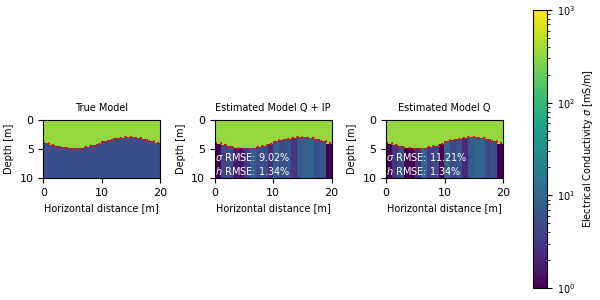

In [7]:
Plot3Models_2lay(model, model_est, model_est_Q, conds)
plt.show()

### 5. Check the error space in a specific position

In [8]:
# For example let's check the following position
pos = 10

# Simulate data for this position
data_est_pos = EMforward2lay(model_est[pos,0], model_est[pos,1], model_est[pos,2], height=0.1)
data_est_pos_norm = data_est_pos * np.hstack([norm, norm, norm, norm, norm, norm])

data_estQ_pos = EMforward2lay(model_est_Q[pos,0], model_est_Q[pos,1], model_est_Q[pos,2], height=0.1)
data_estQ_pos_norm = data_estQ_pos * np.hstack([norm, norm, norm, norm, norm, norm])

# Evaluate error space
err, models_err = ErrorSpace(LUT_norm, data_est_pos_norm, 0.1, conds, thick)
err_Q, models_err_Q = ErrorSpace(LUT_norm, data_estQ_pos_norm, 0.1, conds, thick)

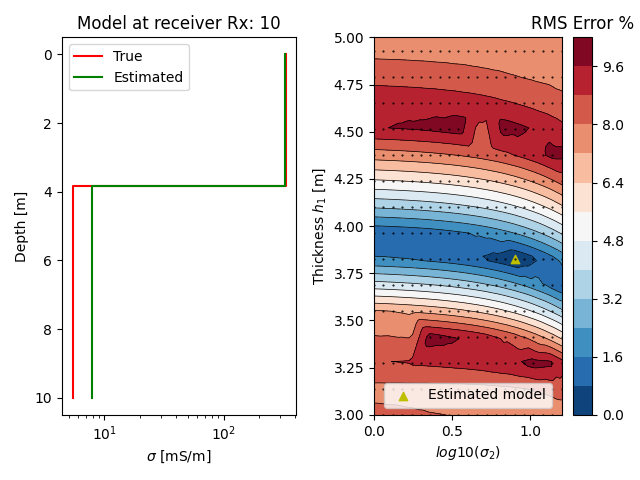

In [9]:
# Error space using Q + IP

PlotErrorSpace(model, model_est, pos, err, models_err)
plt.tight_layout()
plt.show()

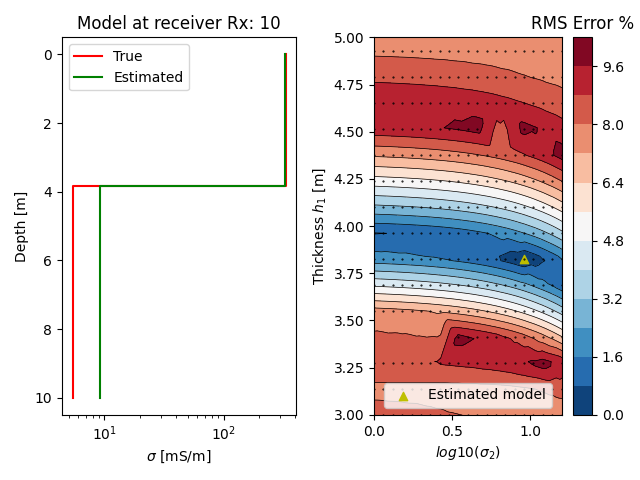

In [10]:
# Error space using Q 
PlotErrorSpace(model, model_est_Q, pos, err_Q, models_err_Q)
plt.tight_layout()
plt.show()

In [11]:
## Let's test the Global search with noise added to data

# Adding noise to data
error = 0.05

data_true_noise = data_true.copy()
data_true_noise *= (np.random.randn(np.size(data_true))*error).reshape(np.shape(data_true)) +1

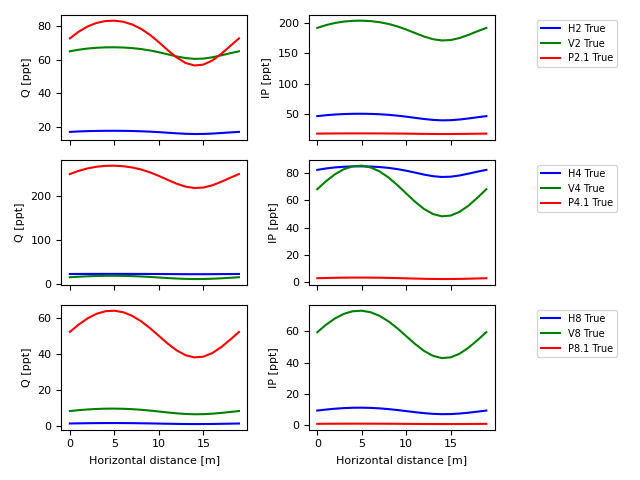

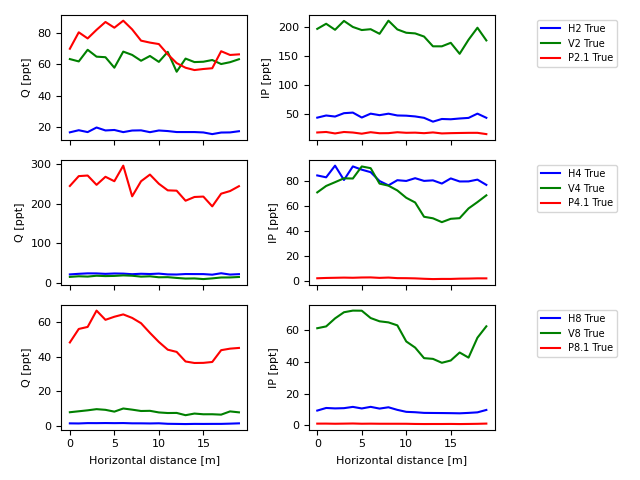

In [12]:

PlotData(data_true)
PlotData(data_true_noise)

In [13]:
data_true_norm_noise = data_true_noise[:] * np.hstack([norm, norm, norm, norm, norm, norm])

model_est_noise = model.copy()
model_est_Q_noise = model.copy()

# Estimate with both Quadrature and In Phase
for p in range(npos):
    model_est_noise[p] = GlobalSearch(LUT_norm, data_true_norm_noise[p], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    model_est_Q_noise[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm_noise[p,:9], conds, thick)

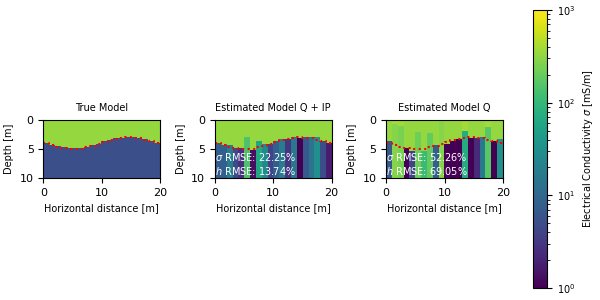

In [14]:
Plot3Models_2lay(model, model_est_noise, model_est_Q_noise, conds)
plt.show()

## Using ML

In [15]:
# Input variables conds and thicks must be in a single array X
# The lookup table is the output variables stored as array Y
# Y = f(X)

X = np.load('../data/models.npy')
Y = np.load('../data/LookupTable2Layers.npy')

dataset = pd.DataFrame(np.hstack((X,Y)), 
                       columns=['sigm1', 'sigm2', 'thick1', 
                                'Q_H_2','Q_H_4','Q_H_8',
                                'Q_V_2','Q_V_4','Q_V_8',
                                'Q_P_2.1','Q_P_4.1','Q_P_8.1',
                                'IP_H_2','IP_H_4','IP_H_8',
                                'IP_V_2','IP_V_4','IP_V_8',
                                'IP_P_2.1','IP_P_4.1','IP_P_8.1'])

In [16]:
train_dataset = dataset.sample(frac=0.2, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
test_dataset = test_dataset.sample(frac=0.2, random_state=0)

In [17]:
#import seaborn as sns
#sns.pairplot(train_dataset[['0','1','2']], diag_kind='kde')

In [18]:
# Inspect the statistics

train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sigm1,26530.0,0.151883,0.241673,1.000000e-03,0.005248,0.031623,0.190546,1.000000
sigm2,26530.0,0.151136,0.239885,1.000000e-03,0.005248,0.031623,0.190546,1.000000
thick1,26530.0,3.557230,2.032781,1.000000e-01,1.756000,3.550000,5.344000,7.000000
Q_H_2,26530.0,0.008138,0.010472,6.973544e-05,0.001017,0.003404,0.011034,0.044602
Q_H_4,26530.0,0.023494,0.024748,2.763871e-04,0.004171,0.013383,0.035668,0.094095
Q_H_8,26530.0,0.040127,0.029338,9.568980e-05,0.012717,0.035816,0.064881,0.106737
Q_V_2,26530.0,0.008442,0.011773,6.381996e-05,0.000823,0.002933,0.010965,0.051037
Q_V_4,26530.0,0.030854,0.039487,2.665653e-04,0.003980,0.013085,0.041925,0.168931
Q_V_8,26530.0,0.093720,0.101459,1.079073e-03,0.016951,0.052367,0.138075,0.406255
Q_P_2.1,26530.0,0.010436,0.015328,7.084164e-05,0.000737,0.003173,0.013246,0.066750


In [19]:
# Split features and labels

train_features = train_dataset.reindex(columns = ['Q_H_2','Q_H_4','Q_H_8',
                                'Q_V_2','Q_V_4','Q_V_8',
                                'Q_P_2.1','Q_P_4.1','Q_P_8.1',
                                'IP_H_2','IP_H_4','IP_H_8',
                                'IP_V_2','IP_V_4','IP_V_8',
                                'IP_P_2.1','IP_P_4.1','IP_P_8.1'])
test_features = test_dataset.reindex(columns = ['Q_H_2','Q_H_4','Q_H_8',
                                'Q_V_2','Q_V_4','Q_V_8',
                                'Q_P_2.1','Q_P_4.1','Q_P_8.1',
                                'IP_H_2','IP_H_4','IP_H_8',
                                'IP_V_2','IP_V_4','IP_V_8',
                                'IP_P_2.1','IP_P_4.1','IP_P_8.1'])

train_labels = train_dataset.reindex(columns= ['sigm1', 'sigm2', 'thick1'])
test_labels = test_dataset.reindex(columns=['sigm1', 'sigm2', 'thick1'])


In [20]:
# Normalize dataset

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[0.00813835 0.02349422 0.04012682 0.00844153 0.0308537  0.09371978
  0.01043568 0.03906522 0.12492826 0.00205551 0.01249257 0.05535799
  0.00111996 0.00755721 0.04260251 0.00071401 0.00670273 0.05076768]]


In [21]:
#When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=5, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[0.00337 0.00689 0.01359 0.00461 0.01401 0.03743 0.00603 0.01722 0.04317
  0.00011 0.00065 0.00367 0.00006 0.0004  0.0024  0.00004 0.00029 0.00185]]

Normalized: [[-0.45556 -0.67097 -0.9046  -0.32558 -0.42647 -0.55481 -0.28722 -0.41166
  -0.57882 -0.56321 -0.61042 -0.73304 -0.54912 -0.57628 -0.63483 -0.46192
  -0.49828 -0.56803]]


### Test Regression with DNN

In [22]:
def build_and_compile_model(norm):
    model = Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(3)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [23]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5608 (21.91 KB)
Trainable params: 5571 (21.76 KB)
Non-trainable params: 37 (152.00 Byte)
_________________________________________________________________


In [24]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3min 23s, sys: 35.5 s, total: 3min 58s
Wall time: 2min 9s


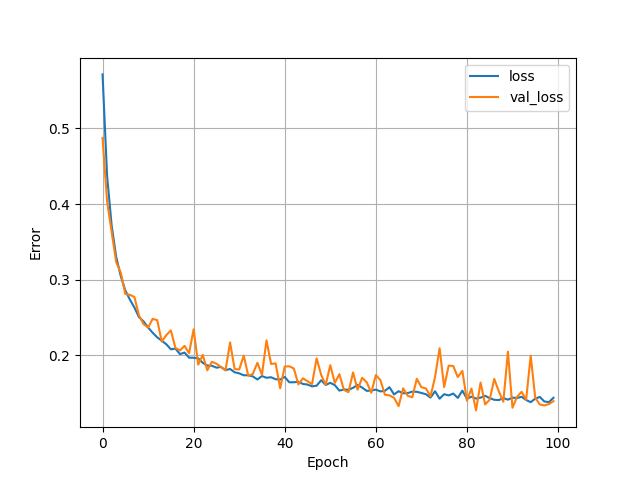

In [25]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)


In [26]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [27]:
test_results

{'dnn_model': 0.1338571012020111}

In [28]:
test_predictions = dnn_model.predict(test_features)

664/664 [==============================] - 1s 1ms/step


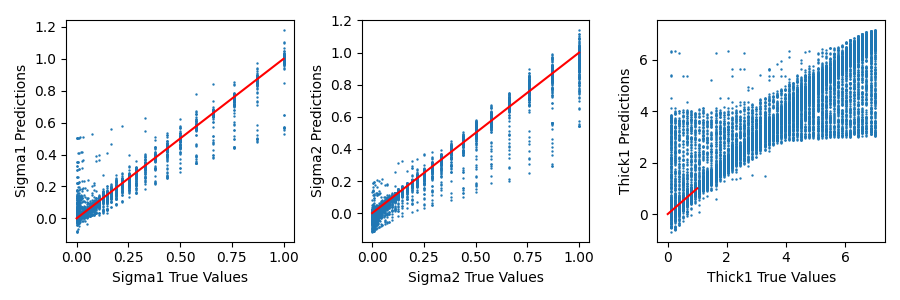

In [29]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

ax[0].scatter(np.array(test_labels)[:,0], test_predictions[0:,0], s= 0.5)
ax[0].plot([0,1],[0,1], 'r')
ax[0].set_xlabel('Sigma1 True Values')
ax[0].set_ylabel('Sigma1 Predictions')

ax[1].scatter(np.array(test_labels)[:,1], test_predictions[0:,1], s=0.5)
ax[1].plot([0,1],[0,1], 'r')
ax[1].set_xlabel('Sigma2 True Values')
ax[1].set_ylabel('Sigma2 Predictions')

ax[2].scatter(np.array(test_labels)[:,2], test_predictions[0:,2], s=0.5)
ax[2].plot([0,1],[0,1], 'r')
ax[2].set_xlabel('Thick1 True Values')
ax[2].set_ylabel('Thick1 Predictions')

plt.tight_layout()

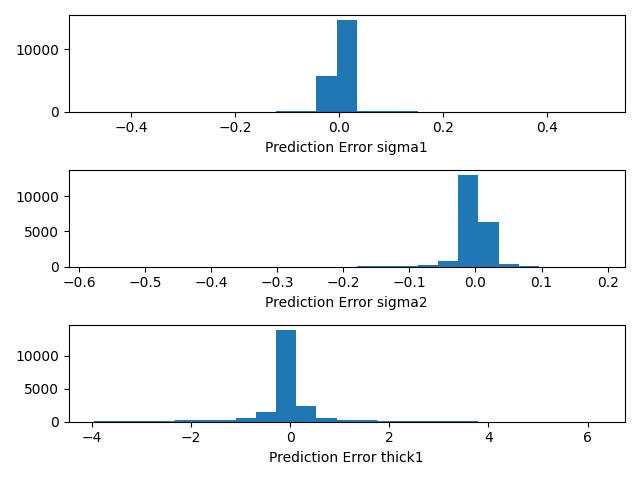

In [30]:
fig, ax = plt.subplots(3,1)
error = test_predictions - np.array(test_labels)
ax[0].hist(error[:,0], bins=25)
ax[1].hist(error[:,1], bins=25)
ax[2].hist(error[:,2], bins=25)
ax[0].set_xlabel('Prediction Error sigma1')
ax[1].set_xlabel('Prediction Error sigma2')
ax[2].set_xlabel('Prediction Error thick1')

plt.tight_layout()

## Test the ML model with the 2D stitched section

In [35]:
# Predict a model using the DNN

model_pred = dnn_model.predict(data_true)

1/1 [==============================] - 0s 24ms/step


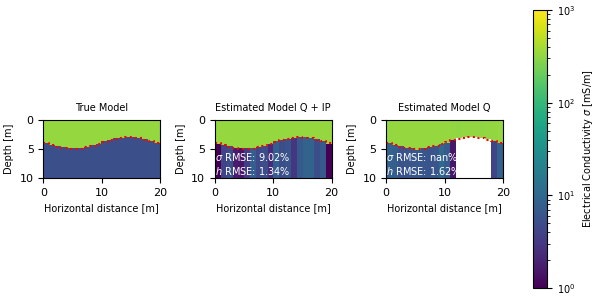

In [36]:
# The model to the right is the predicted model using DNN

Plot3Models_2lay(model, model_est, model_pred, conds)

In [37]:
# Predict a model using the DNN

model_pred_noise = dnn_model.predict(data_true_noise)

1/1 [==============================] - 0s 20ms/step


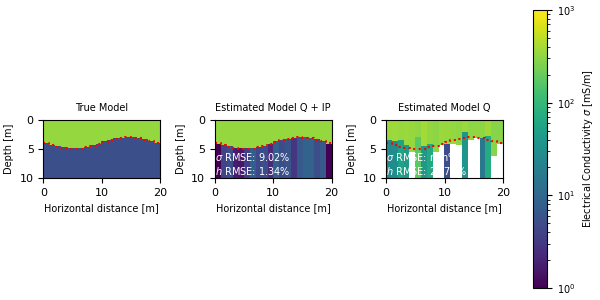

In [38]:
# The model to the right is the predicted model using DNN

Plot3Models_2lay(model, model_est, model_pred_noise, conds)

### Check if there is overfit

the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would overfit to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the training set, what you really want is to develop models that generalize well to a testing set (or data they haven't seen before).

In [54]:
N_TRAIN = len(train_dataset)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# The code above sets a tf.keras.optimizers.schedules.InverseTimeDecay to hyperbolically decrease
# the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

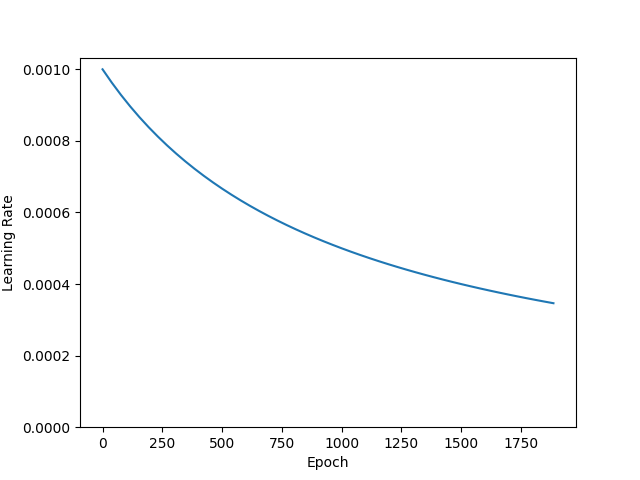

In [55]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use c`allbacks.TensorBoard` to generate TensorBoard logs for the training.

In [56]:
import pathlib
import shutil
import tempfile

In [80]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [81]:
def get_callbacks(name):
    return [
   # tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [83]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
#    model.compile(optimizer=optimizer,
#                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                metrics=[
#                  tf.keras.metrics.BinaryCrossentropy(
#                      from_logits=True, name='binary_crossentropy'),
#                  'accuracy'])
    
    model.compile(loss='mean_absolute_error',
                optimizer=optimizer)

    model.summary()

    history = model.fit(
        train_features,
        train_labels,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=0.2,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [84]:
size_histories = {}

Tiny_model = Sequential([
      normalizer,
      layers.Dense(18, activation='relu'),
      layers.Dense(3)
    ])

size_histories['Tiny'] = compile_and_fit(Tiny_model, 'Tiny')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense_24 (Dense)            (None, 18)                342       
                                                                 
 dense_25 (Dense)            (None, 3)                 57        
                                                                 
Total params: 436 (1.71 KB)
Trainable params: 399 (1.56 KB)
Non-trainable params: 37 (152.00 Byte)
_________________________________________________________________


KeyboardInterrupt: 

In [ ]:
# Repeat for several sizes 

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)